# Imports

In [19]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

import sys, os
sys.path.insert(0, os.path.abspath(".."))

from src.model_comparison import create_memory_cache, train_model, train_with_pca, evaluate
import sklearn
sklearn.set_config(working_memory=12000)

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Configuration

In [20]:
memory = create_memory_cache()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Load Data

In [21]:
x_train = pd.read_csv("x_train_scaled.csv")
x_test = pd.read_csv("x_test_scaled.csv")
y_train = pd.read_csv("y_train.csv").squeeze()
y_test = pd.read_csv("y_test.csv").squeeze()

In [22]:
y_train.value_counts()

label
1    217
0    217
Name: count, dtype: int64

In [23]:
y_test.value_counts()

stroke
0    424
1     26
Name: count, dtype: int64

# MODELS

## SVC

In [24]:
svc_pipeline = Pipeline([('svc', SVC(probability=True))], memory=memory)
svc_params = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['rbf', 'linear'],
    'svc__gamma': ['scale', 'auto']
}
svc_grid, svc_preds = train_model("SVC", svc_pipeline, svc_params, x_train, y_train, x_test, y_test, cv)

🔹 Training SVC...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

SVC
---
Accuracy: 0.7267
F1 Score (macro): 0.5599


## LDA

In [25]:
lda_pipeline = Pipeline([('lda', LDA(solver='lsqr', shrinkage='auto'))], memory=memory)
lda_grid, lda_preds = train_model("LDA", lda_pipeline, {}, x_train, y_train, x_test, y_test, cv)

🔹 Training LDA...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

LDA
---
Accuracy: 0.7244
F1 Score (macro): 0.5544


## Random Forest

In [26]:
rf_pipeline = Pipeline([('rf', RandomForestClassifier(random_state=42))], memory=memory)
rf_params = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}
rf_grid, rf_preds = train_model("Random Forest", rf_pipeline, rf_params, x_train, y_train, x_test, y_test, cv)

🔹 Training Random Forest...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Random Forest
-------------
Accuracy: 0.7267
F1 Score (macro): 0.5599


## XGBoost

In [27]:
xgb_pipeline = Pipeline([('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))], memory=memory)
xgb_params = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 6, 9],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.8, 1],
    'xgb__colsample_bytree': [0.8, 1]
}
xgb_grid, xgb_preds = train_model("XGBoost", xgb_pipeline, xgb_params, x_train, y_train, x_test, y_test, cv)

🔹 Training XGBoost...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

XGBoost
-------
Accuracy: 0.7267
F1 Score (macro): 0.5599


C:\Users\Konrad\Desktop\StrokePredictionML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:54:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Stacking

In [28]:
stacking = StackingClassifier(
    estimators=[
        ('svc', svc_grid.best_estimator_),
        ('rf', rf_grid.best_estimator_),
        ('xgb', xgb_grid.best_estimator_)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=cv,
    n_jobs=-1
)
stacking.fit(x_train, y_train)
stacking_preds = stacking.predict(x_test)
evaluate("Stacking", y_test, stacking_preds)


Stacking
--------
Accuracy: 0.7356
F1 Score (macro): 0.5625


# PCA ANALYSIS


🔵 Training SVC with PCA (5 components)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

📊 SVC + PCA (5)
----------------------------------------
Accuracy       : 0.6933
F1 Score (macro): 0.5361
Precision       : 0.5754
Recall          : 0.8192

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.68      0.81       424
           1       0.15      0.96      0.27        26

    accuracy                           0.69       450
   macro avg       0.58      0.82      0.54       450
weighted avg       0.95      0.69      0.77       450


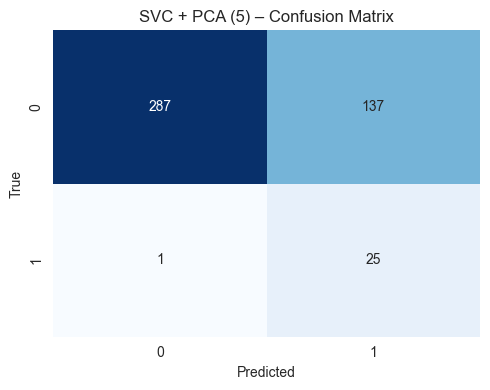


🔵 Training SVC with PCA (10 components)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

📊 SVC + PCA (10)
----------------------------------------
Accuracy       : 0.7089
F1 Score (macro): 0.5432
Precision       : 0.5751
Recall          : 0.8094

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       424
           1       0.16      0.92      0.27        26

    accuracy                           0.71       450
   macro avg       0.58      0.81      0.54       450
weighted avg       0.94      0.71      0.79       450


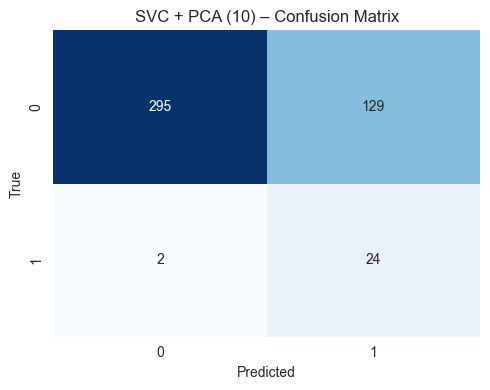


🔵 Training SVC with PCA (11 components)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

📊 SVC + PCA (11)
----------------------------------------
Accuracy       : 0.6933
F1 Score (macro): 0.5324
Precision       : 0.5716
Recall          : 0.8012

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.68      0.81       424
           1       0.15      0.92      0.26        26

    accuracy                           0.69       450
   macro avg       0.57      0.80      0.53       450
weighted avg       0.94      0.69      0.78       450


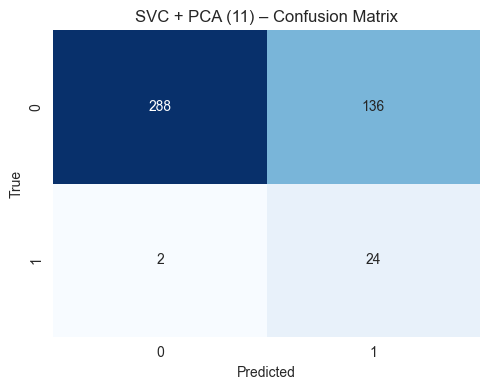


🔵 Training SVC with PCA (12 components)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

📊 SVC + PCA (12)
----------------------------------------
Accuracy       : 0.7244
F1 Score (macro): 0.5583
Precision       : 0.5828
Recall          : 0.8357

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       424
           1       0.17      0.96      0.29        26

    accuracy                           0.72       450
   macro avg       0.58      0.84      0.56       450
weighted avg       0.95      0.72      0.80       450


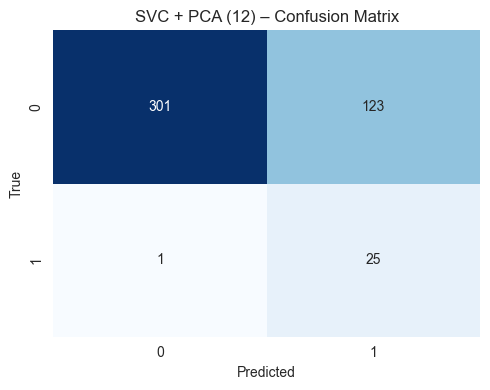


🔵 Training SVC with PCA (13 components)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

📊 SVC + PCA (13)
----------------------------------------
Accuracy       : 0.7267
F1 Score (macro): 0.5599
Precision       : 0.5834
Recall          : 0.8369

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       424
           1       0.17      0.96      0.29        26

    accuracy                           0.73       450
   macro avg       0.58      0.84      0.56       450
weighted avg       0.95      0.73      0.80       450


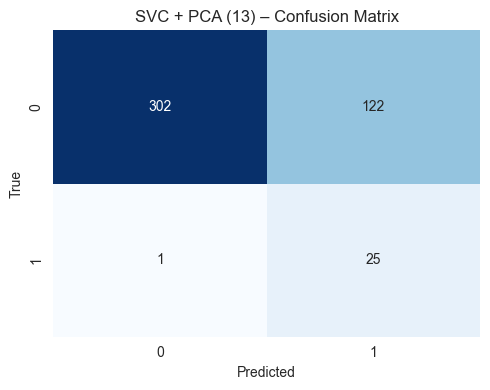


🔵 Training SVC with PCA (14 components)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

📊 SVC + PCA (14)
----------------------------------------
Accuracy       : 0.7267
F1 Score (macro): 0.5599
Precision       : 0.5834
Recall          : 0.8369

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       424
           1       0.17      0.96      0.29        26

    accuracy                           0.73       450
   macro avg       0.58      0.84      0.56       450
weighted avg       0.95      0.73      0.80       450


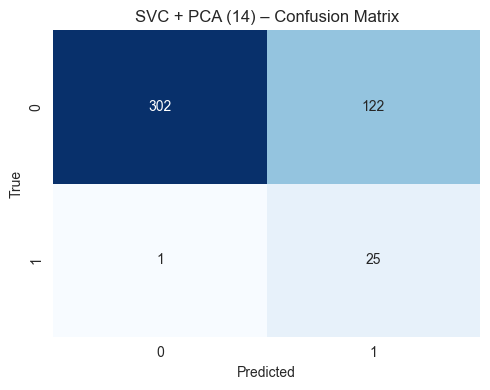


🔵 Training SVC with PCA (15 components)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

📊 SVC + PCA (15)
----------------------------------------
Accuracy       : 0.7267
F1 Score (macro): 0.5599
Precision       : 0.5834
Recall          : 0.8369

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       424
           1       0.17      0.96      0.29        26

    accuracy                           0.73       450
   macro avg       0.58      0.84      0.56       450
weighted avg       0.95      0.73      0.80       450


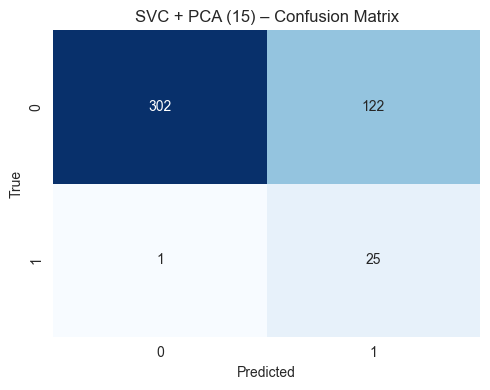


🔵 Training RF with PCA (5 components)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

📊 RF + PCA (5)
----------------------------------------
Accuracy       : 0.7178
F1 Score (macro): 0.5415
Precision       : 0.5693
Recall          : 0.7780

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.71      0.83       424
           1       0.15      0.85      0.26        26

    accuracy                           0.72       450
   macro avg       0.57      0.78      0.54       450
weighted avg       0.94      0.72      0.79       450


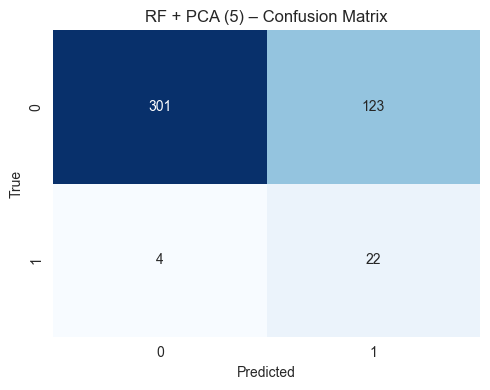


🔵 Training RF with PCA (10 components)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

📊 RF + PCA (10)
----------------------------------------
Accuracy       : 0.6978
F1 Score (macro): 0.5278
Precision       : 0.5647
Recall          : 0.7674

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.69      0.81       424
           1       0.14      0.85      0.24        26

    accuracy                           0.70       450
   macro avg       0.56      0.77      0.53       450
weighted avg       0.94      0.70      0.78       450


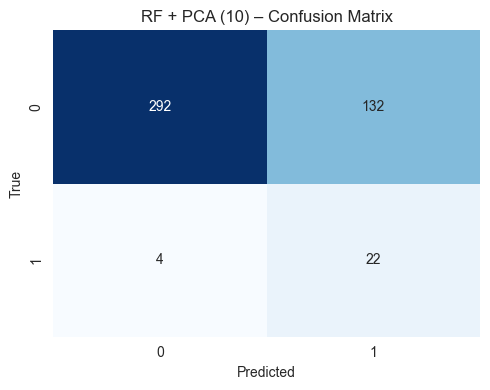


🔵 Training RF with PCA (11 components)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

📊 RF + PCA (11)
----------------------------------------
Accuracy       : 0.6978
F1 Score (macro): 0.5278
Precision       : 0.5647
Recall          : 0.7674

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.69      0.81       424
           1       0.14      0.85      0.24        26

    accuracy                           0.70       450
   macro avg       0.56      0.77      0.53       450
weighted avg       0.94      0.70      0.78       450


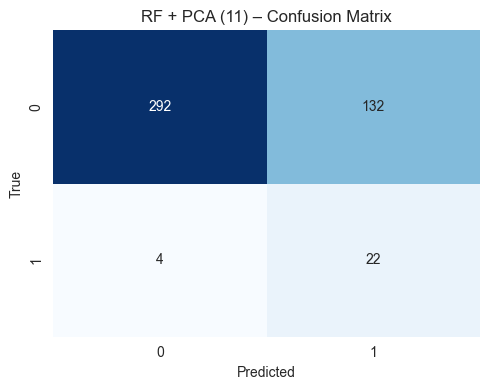


🔵 Training RF with PCA (12 components)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

📊 RF + PCA (12)
----------------------------------------
Accuracy       : 0.6978
F1 Score (macro): 0.5355
Precision       : 0.5725
Recall          : 0.8035

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.68      0.81       424
           1       0.15      0.92      0.26        26

    accuracy                           0.70       450
   macro avg       0.57      0.80      0.54       450
weighted avg       0.94      0.70      0.78       450


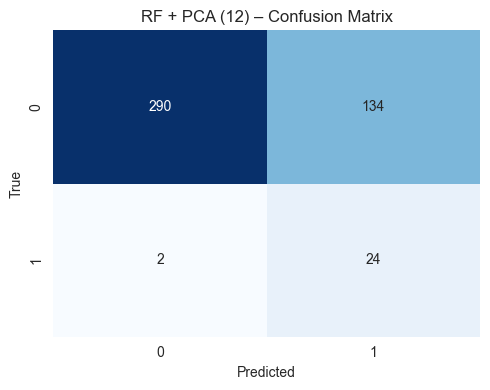


🔵 Training RF with PCA (13 components)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

📊 RF + PCA (13)
----------------------------------------
Accuracy       : 0.7022
F1 Score (macro): 0.5347
Precision       : 0.5696
Recall          : 0.7878

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.69      0.81       424
           1       0.15      0.88      0.26        26

    accuracy                           0.70       450
   macro avg       0.57      0.79      0.53       450
weighted avg       0.94      0.70      0.78       450


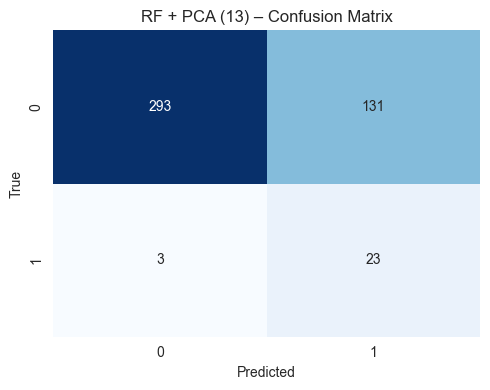


🔵 Training RF with PCA (14 components)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

📊 RF + PCA (14)
----------------------------------------
Accuracy       : 0.7156
F1 Score (macro): 0.5480
Precision       : 0.5767
Recall          : 0.8130

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       424
           1       0.16      0.92      0.27        26

    accuracy                           0.72       450
   macro avg       0.58      0.81      0.55       450
weighted avg       0.95      0.72      0.79       450


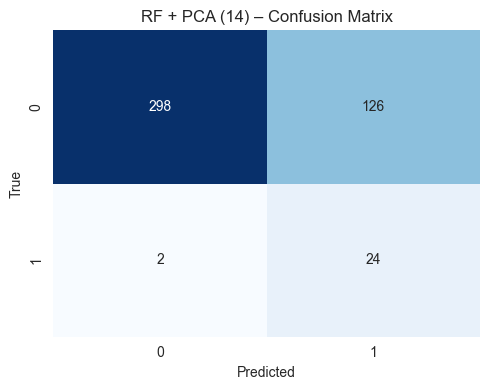


🔵 Training RF with PCA (15 components)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

📊 RF + PCA (15)
----------------------------------------
Accuracy       : 0.7200
F1 Score (macro): 0.5550
Precision       : 0.5817
Recall          : 0.8334

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       424
           1       0.17      0.96      0.28        26

    accuracy                           0.72       450
   macro avg       0.58      0.83      0.56       450
weighted avg       0.95      0.72      0.79       450


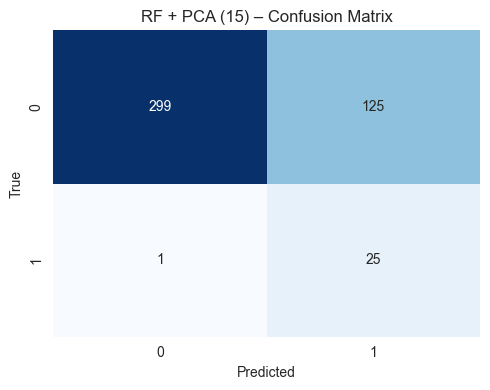


🔵 Training XGB with PCA (5 components)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

📊 XGB + PCA (5)
----------------------------------------
Accuracy       : 0.7000
F1 Score (macro): 0.5370
Precision       : 0.5730
Recall          : 0.8047

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.69      0.81       424
           1       0.15      0.92      0.26        26

    accuracy                           0.70       450
   macro avg       0.57      0.80      0.54       450
weighted avg       0.94      0.70      0.78       450


C:\Users\Konrad\Desktop\StrokePredictionML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:55:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


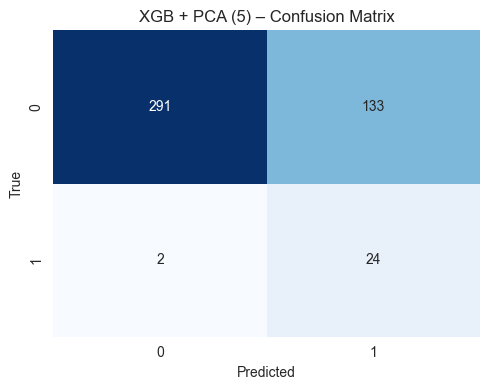


🔵 Training XGB with PCA (10 components)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

📊 XGB + PCA (10)
----------------------------------------
Accuracy       : 0.7067
F1 Score (macro): 0.5454
Precision       : 0.5784
Recall          : 0.8263

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.69      0.82       424
           1       0.16      0.96      0.27        26

    accuracy                           0.71       450
   macro avg       0.58      0.83      0.55       450
weighted avg       0.95      0.71      0.78       450


C:\Users\Konrad\Desktop\StrokePredictionML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:55:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


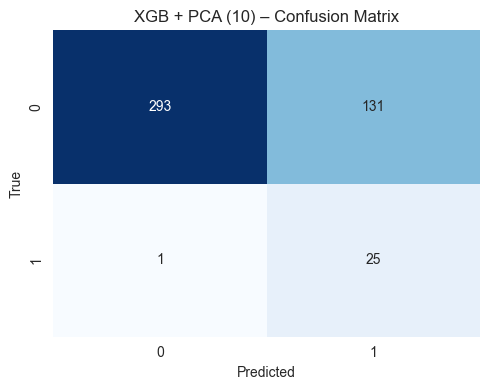


🔵 Training XGB with PCA (11 components)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

📊 XGB + PCA (11)
----------------------------------------
Accuracy       : 0.7044
F1 Score (macro): 0.5439
Precision       : 0.5779
Recall          : 0.8251

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.69      0.81       424
           1       0.16      0.96      0.27        26

    accuracy                           0.70       450
   macro avg       0.58      0.83      0.54       450
weighted avg       0.95      0.70      0.78       450


C:\Users\Konrad\Desktop\StrokePredictionML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:55:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


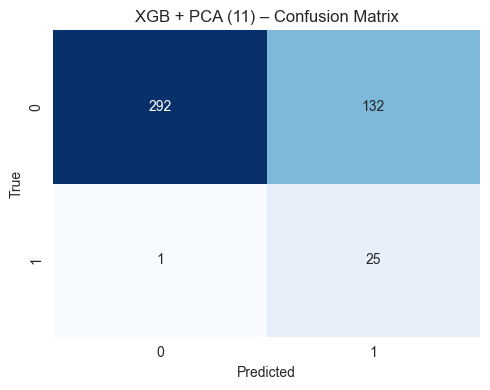


🔵 Training XGB with PCA (12 components)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

📊 XGB + PCA (12)
----------------------------------------
Accuracy       : 0.7200
F1 Score (macro): 0.5550
Precision       : 0.5817
Recall          : 0.8334

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       424
           1       0.17      0.96      0.28        26

    accuracy                           0.72       450
   macro avg       0.58      0.83      0.56       450
weighted avg       0.95      0.72      0.79       450


C:\Users\Konrad\Desktop\StrokePredictionML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:55:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


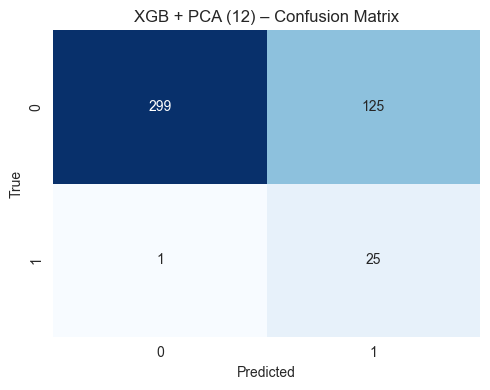


🔵 Training XGB with PCA (13 components)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

📊 XGB + PCA (13)
----------------------------------------
Accuracy       : 0.7200
F1 Score (macro): 0.5550
Precision       : 0.5817
Recall          : 0.8334

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       424
           1       0.17      0.96      0.28        26

    accuracy                           0.72       450
   macro avg       0.58      0.83      0.56       450
weighted avg       0.95      0.72      0.79       450


C:\Users\Konrad\Desktop\StrokePredictionML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:55:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


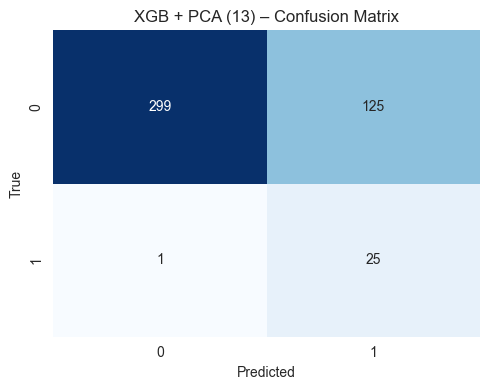


🔵 Training XGB with PCA (14 components)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

📊 XGB + PCA (14)
----------------------------------------
Accuracy       : 0.7089
F1 Score (macro): 0.5470
Precision       : 0.5790
Recall          : 0.8275

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.69      0.82       424
           1       0.16      0.96      0.28        26

    accuracy                           0.71       450
   macro avg       0.58      0.83      0.55       450
weighted avg       0.95      0.71      0.79       450


C:\Users\Konrad\Desktop\StrokePredictionML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:55:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


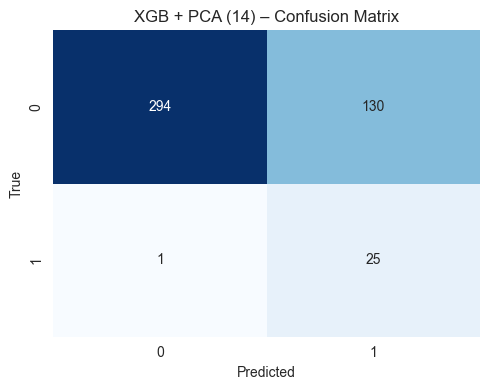


🔵 Training XGB with PCA (15 components)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

📊 XGB + PCA (15)
----------------------------------------
Accuracy       : 0.7022
F1 Score (macro): 0.5423
Precision       : 0.5774
Recall          : 0.8239

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.69      0.81       424
           1       0.16      0.96      0.27        26

    accuracy                           0.70       450
   macro avg       0.58      0.82      0.54       450
weighted avg       0.95      0.70      0.78       450


C:\Users\Konrad\Desktop\StrokePredictionML\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:55:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


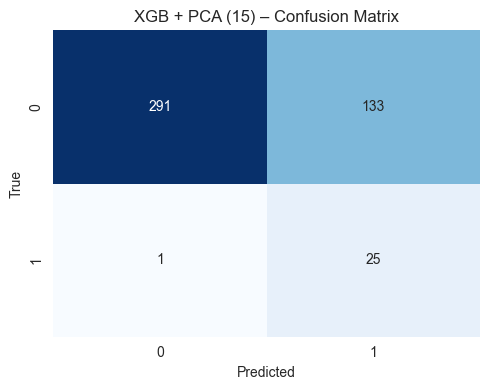

In [29]:
train_with_pca('svc', SVC(probability=True), svc_params, x_train, y_train, x_test, y_test, cv, memory)
train_with_pca('rf', RandomForestClassifier(random_state=42), rf_params, x_train, y_train, x_test, y_test, cv, memory)
train_with_pca('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), xgb_params, x_train, y_train, x_test, y_test, cv, memory)